Load the data and define the new target variable

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Load the data
df_0 = pd.read_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4_now with indo new.csv")

# Define the target variable and numeric columns
target = 'fgp_name'  # Change target variable
numeric_cols_df_0 = df_0.select_dtypes(include=[np.number]).columns.tolist()
string_cols_df_0 = df_0.select_dtypes(exclude=[np.number]).columns.tolist()

# Drop non-numeric columns and target column from numeric columns list
numeric_cols_df_0 = [col for col in numeric_cols_df_0 if col not in string_cols_df_0]


Train a RandomForest model to get feature importances

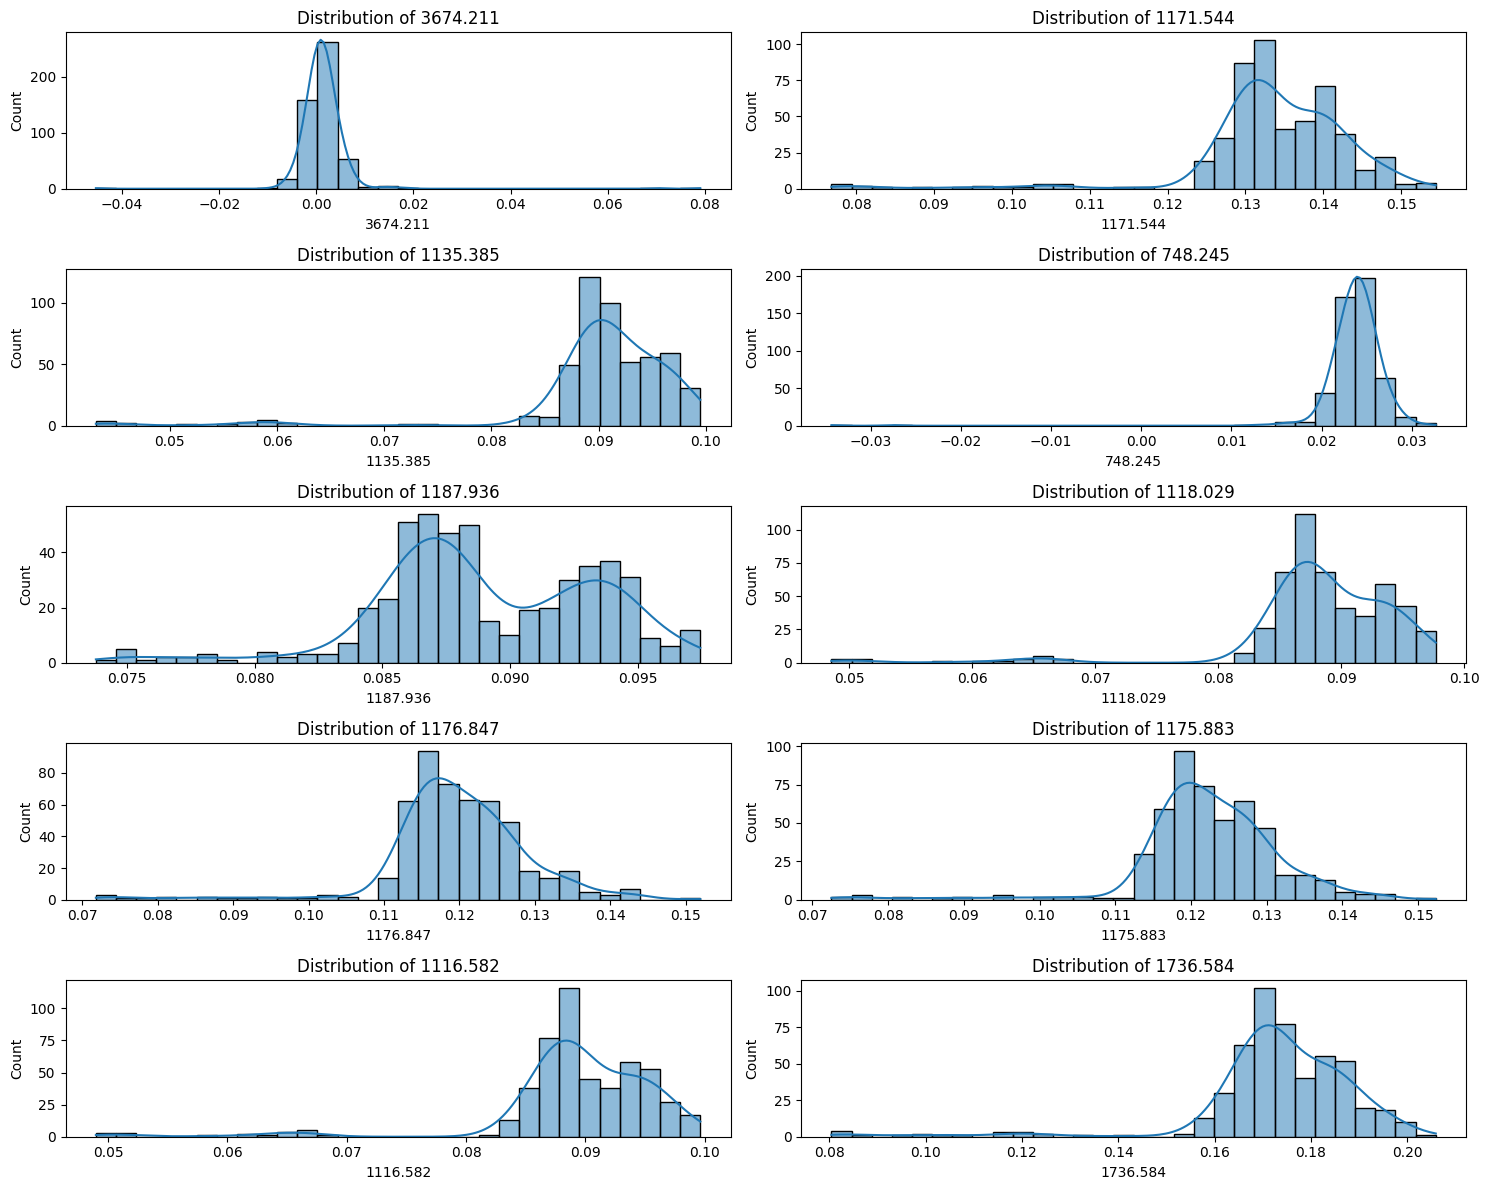

In [2]:
# Train a RandomForest model to get feature importances
X = df_0[numeric_cols_df_0]
y = df_0[target]

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

# Plot the distribution of the top 10 most important features
plt.figure(figsize=(15, 12))
for i, idx in enumerate(indices):
    plt.subplot(5, 2, i + 1)
    sns.histplot(df_0[numeric_cols_df_0[idx]], bins=30, kde=True)
    plt.title(f'Distribution of {numeric_cols_df_0[idx]}')
plt.tight_layout()
plt.show()


Remove outliers using Z-score

Original Data Shape: (503, 6958)
Cleaned Data Shape: (481, 6958)


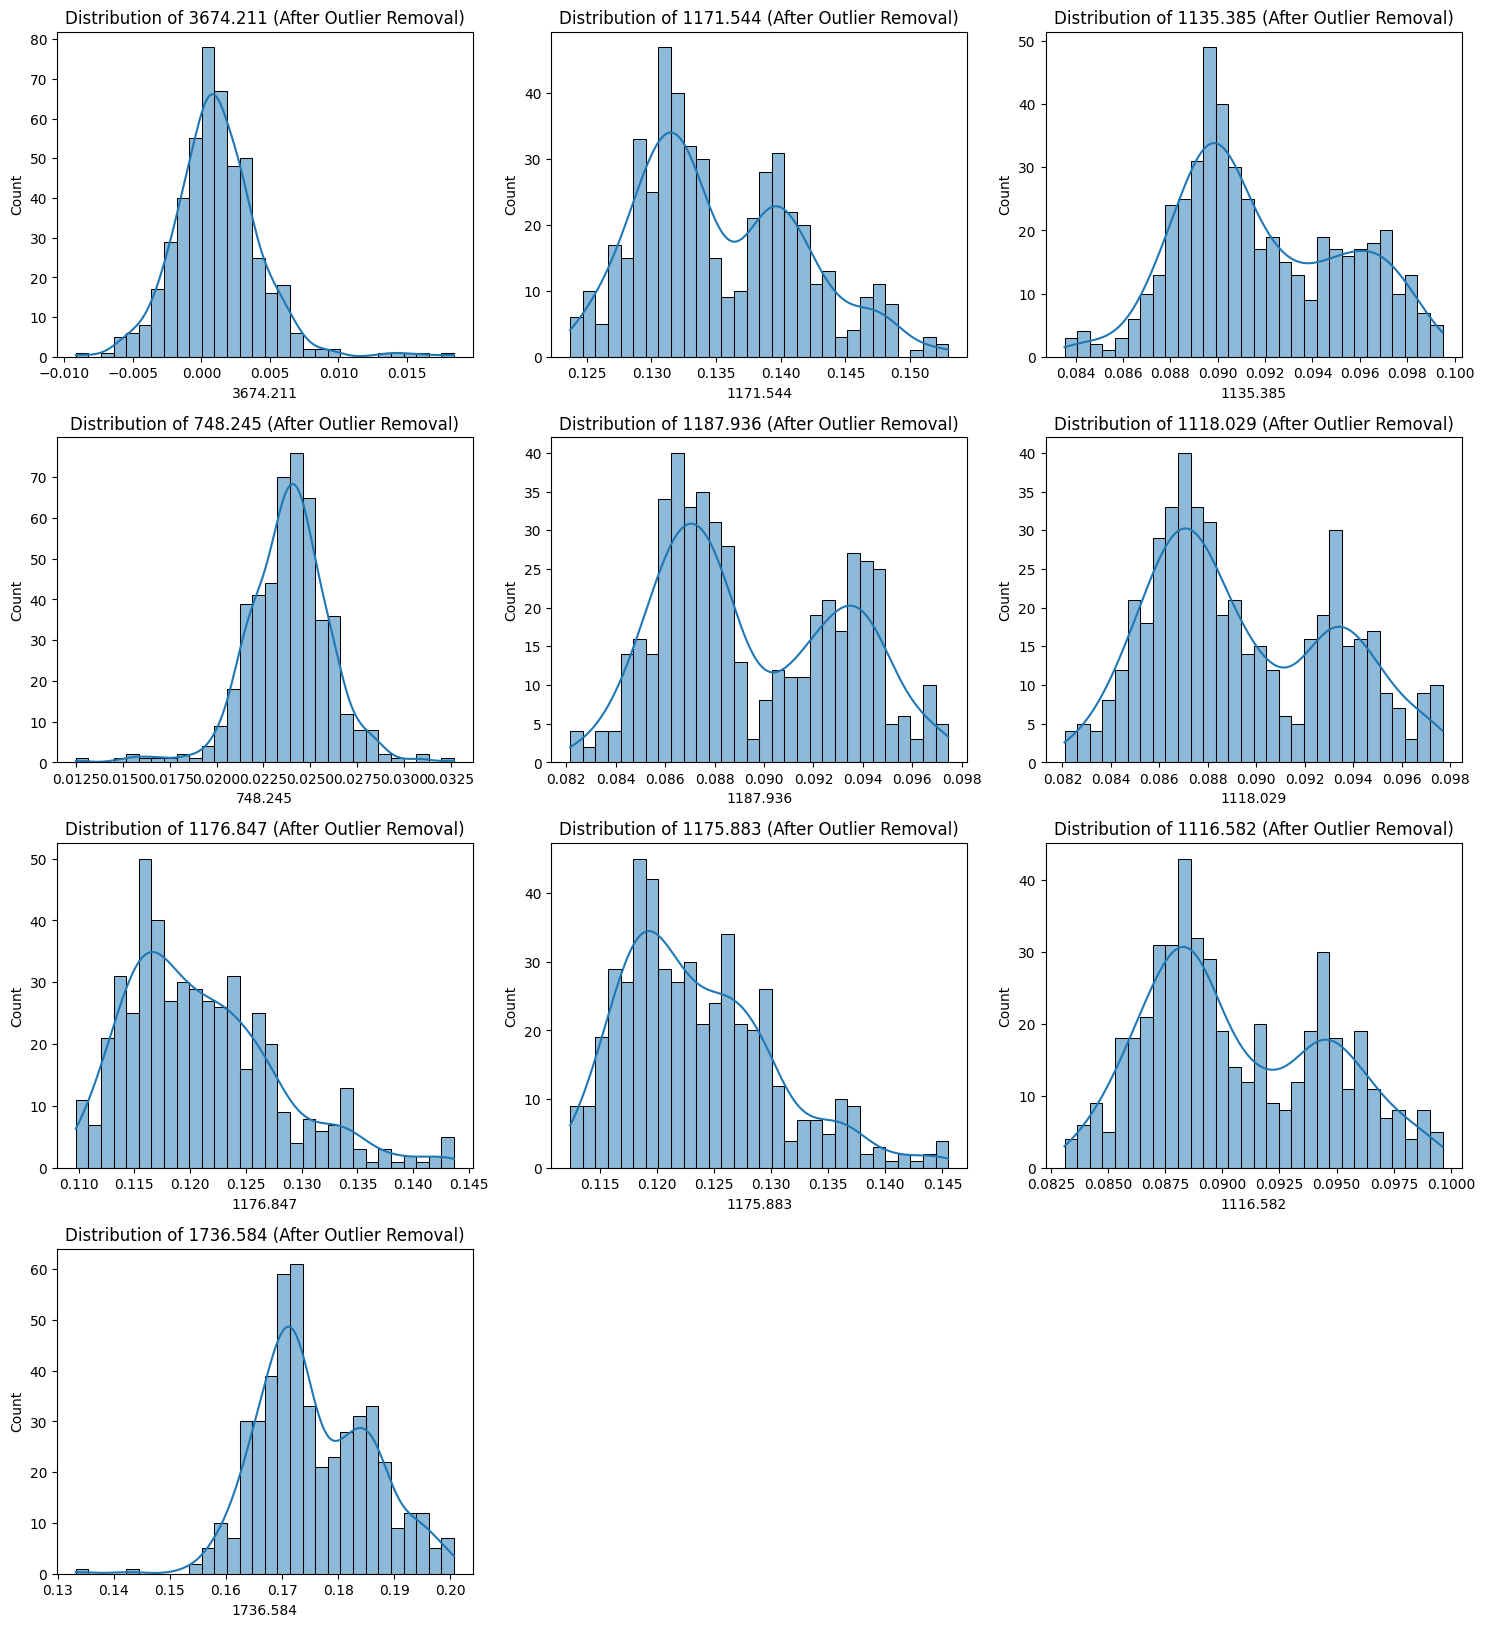

In [3]:
from scipy import stats

# Define a function to remove outliers using Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    return df[(z_scores < threshold).all(axis=1)]

# Remove outliers from the top 10 important features
top_features = [numeric_cols_df_0[idx] for idx in indices]
df_0_cleaned = remove_outliers_zscore(df_0, top_features)

# Check the shape of the cleaned dataframe
print("Original Data Shape:", df_0.shape)
print("Cleaned Data Shape:", df_0_cleaned.shape)

# Plot the distribution of the top 10 most important features after outlier removal
plt.figure(figsize=(15, 20))
for i, feature in enumerate(top_features):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df_0_cleaned[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature} (After Outlier Removal)')
plt.tight_layout()
plt.show()


Create a distribution plot for fgp_name

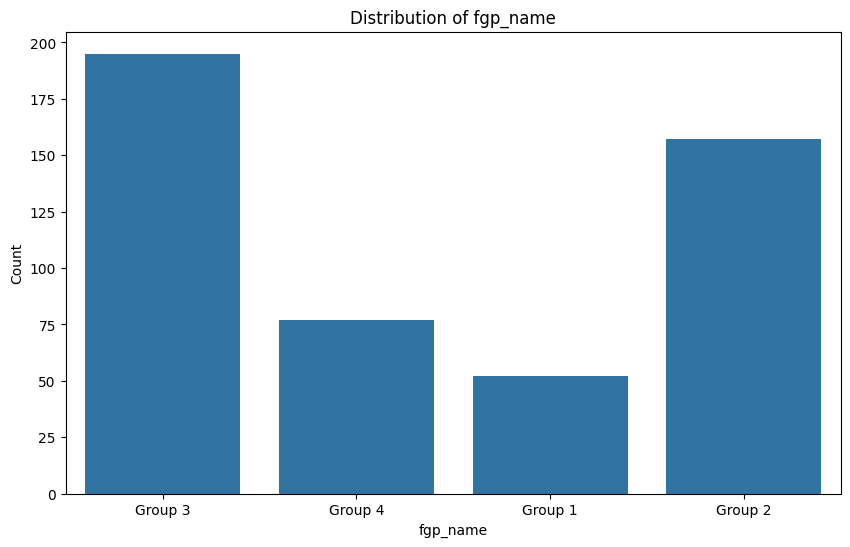

New distribution of fgp_name:
fgp_name
Group 3    195
Group 2    157
Group 4     77
Group 1     52
Name: count, dtype: int64


In [4]:
# Create a distribution plot for 'fgp_name'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_0_cleaned, x=target)
plt.title('Distribution of fgp_name')
plt.xlabel('fgp_name')
plt.ylabel('Count')
plt.show()

# Verify the new distribution
print("New distribution of fgp_name:")
print(df_0_cleaned[target].value_counts())


Separate Group samples and remove outliers using Isolation Forest

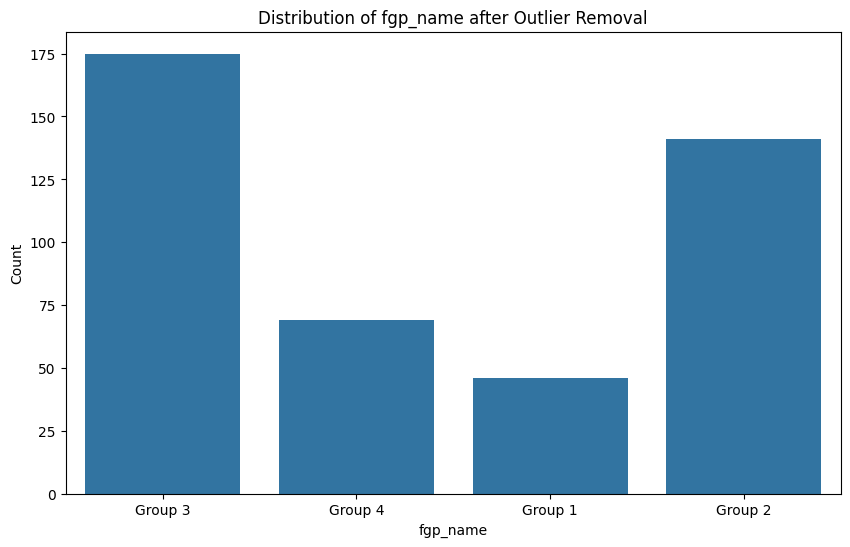

New distribution of fgp_name:
fgp_name
Group 3    175
Group 2    141
Group 4     69
Group 1     46
Name: count, dtype: int64


In [5]:
# Separate samples for each group
groups = df_0_cleaned[target].unique()
df_cleaned_groups = []

from sklearn.ensemble import IsolationForest

# Identify and remove outliers in each group using Isolation Forest
for group in groups:
    df_group = df_0_cleaned[df_0_cleaned[target] == group]
    iso = IsolationForest(contamination=0.1, random_state=42)
    yhat = iso.fit_predict(df_group[numeric_cols_df_0])
    mask = yhat != -1
    df_cleaned_group = df_group[mask]
    df_cleaned_groups.append(df_cleaned_group)

# Combine the cleaned group samples
df_1_cleaned = pd.concat(df_cleaned_groups, axis=0).reset_index(drop=True)

# Plot the distribution of fgp_name after outlier removal
plt.figure(figsize=(10, 6))
sns.countplot(data=df_1_cleaned, x=target)
plt.title('Distribution of fgp_name after Outlier Removal')
plt.xlabel('fgp_name')
plt.ylabel('Count')
plt.show()

# Verify the new distribution
print("New distribution of fgp_name:")
print(df_1_cleaned[target].value_counts())


Encode the tgp_name column and balance the dataset using RandomUnderSampler

fgp_name
Group 1    46
Group 2    46
Group 3    46
Group 4    46
Name: count, dtype: int64


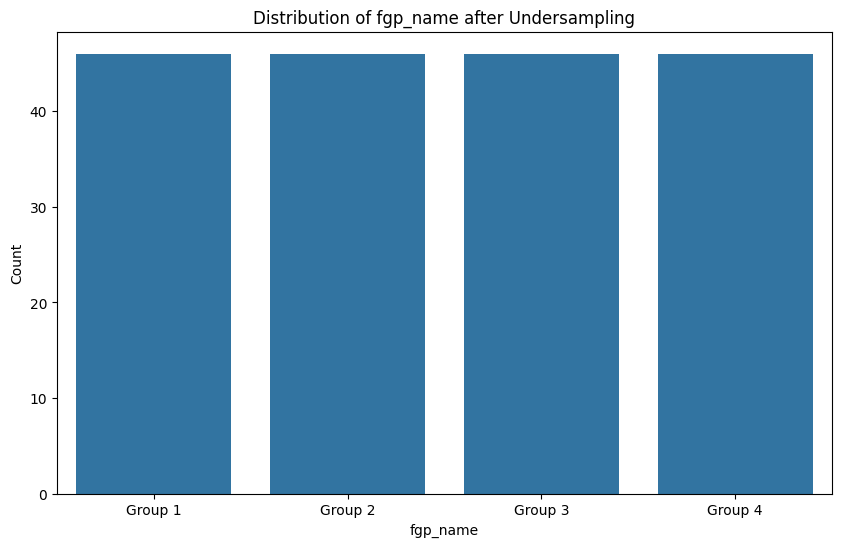

In [6]:
df_2 = df_1_cleaned.copy()

from sklearn.preprocessing import LabelEncoder

# Encoding the 'fgp_name' column
le = LabelEncoder()
df_2['fgp_name_encoded'] = le.fit_transform(df_2['fgp_name'])

# Define the target variable and numeric columns
numeric_cols_df_2 = df_2.select_dtypes(include=[np.number]).columns.tolist()
string_cols_df_2 = df_2.select_dtypes(exclude=[np.number]).columns.tolist()

# Drop non-numeric columns and target column from numeric columns list
numeric_cols_df_2 = [col for col in numeric_cols_df_2 if col not in string_cols_df_2]

# Train a RandomForest model to get feature importances
X_df_2 = df_2[numeric_cols_df_2].drop(columns=['fgp_name_encoded'])
y_df_2 = df_2['fgp_name_encoded'].values

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# Initial model training to find consistent samples
rf = RandomForestClassifier(random_state=42)
rf.fit(X_df_2, y_df_2)

# Get predictions
df_2['predictions'] = rf.predict(X_df_2)

# Keep samples that are correctly classified
consistent_samples = df_2[df_2['fgp_name_encoded'] == df_2['predictions']]

# Separate features and target again with consistent samples
X_df_2_consistent = consistent_samples.drop(columns=['fgp_name', 'fgp_name_encoded', 'predictions'])
y_df_2_consistent = consistent_samples['fgp_name_encoded'].values

# Ensure X_df_2_consistent contains only numeric columns
X_df_2_consistent = X_df_2_consistent.select_dtypes(include=[np.number])

# Apply undersampling to achieve a balanced dataset without specifying exact numbers
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_df_2_balanced, y_df_2_balanced = rus.fit_resample(X_df_2_consistent, y_df_2_consistent)

# Display the new distribution of 'fgp_name'
balanced_df = consistent_samples.iloc[rus.sample_indices_]
fgp_name_distribution = balanced_df['fgp_name'].value_counts()
print(fgp_name_distribution)

# Check the distribution of 'fgp_name' after undersampling
plt.figure(figsize=(10, 6))
sns.countplot(data=balanced_df, x='fgp_name')
plt.title('Distribution of fgp_name after Undersampling')
plt.xlabel('fgp_name')
plt.ylabel('Count')
plt.show()


Perform Leave-One-Group-Out Cross-Validation

Mean Accuracy: 0.41376517001517005
Left out group: ['BBX'], Accuracy: 0.7142857142857143
Left out group: ['CBI'], Accuracy: 0.36363636363636365
Left out group: ['CCO'], Accuracy: 0.0
Left out group: ['CPN'], Accuracy: 0.35714285714285715
Left out group: ['KBI'], Accuracy: 0.6
Left out group: ['KBX'], Accuracy: 0.0
Left out group: ['KRI'], Accuracy: 1.0
Left out group: ['KTX'], Accuracy: 0.0
Left out group: ['NRT'], Accuracy: 0.3333333333333333
Left out group: ['NWT'], Accuracy: 0.4
Left out group: ['PKN'], Accuracy: 0.9230769230769231
Left out group: ['PLG'], Accuracy: 1.0
Left out group: ['PNA'], Accuracy: 0.0
Left out group: ['PTN'], Accuracy: 0.0
Left out group: ['RIX'], Accuracy: 0.0
Left out group: ['RNG'], Accuracy: 0.0
Left out group: ['SGR'], Accuracy: 1.0
Left out group: ['SKM'], Accuracy: 0.0
Left out group: ['SNI'], Accuracy: 0.3333333333333333
Left out group: ['SNK'], Accuracy: 0.8
Left out group: ['SSX'], Accuracy: 0.75
Left out group: ['STN'], Accuracy: 0.8
Left out group

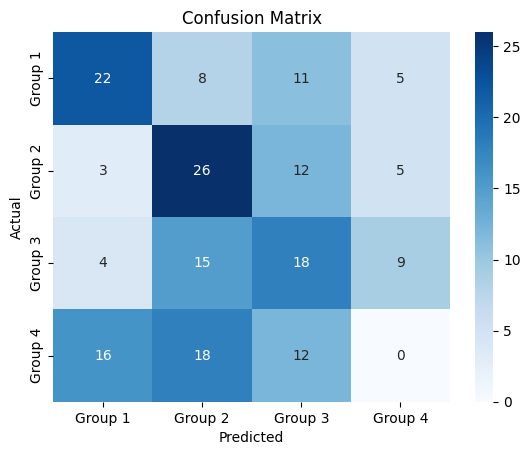

C:\Users\pingk\AppData\Local\Temp\ipykernel_19048\3313806097.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balanced_df.drop(columns=['fgp_name_encoded', 'predictions'], inplace=True)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and encode the 'prov_char' column
le_prov = LabelEncoder()
prov_char_encoded = le_prov.fit_transform(balanced_df['prov_char'])

# Define features and target for the balanced dataset
X_balanced = balanced_df.drop(columns=['fgp_name', 'fgp_name_encoded'])
y_balanced = balanced_df['fgp_name_encoded'].values

# Ensure X_balanced contains only numeric columns
X_balanced = X_balanced.select_dtypes(include=[np.number])

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Arrays to store results
accuracies = []
left_out_groups = []
all_y_test = []
all_y_pred = []

# Perform LOGO-CV
for train_idx, test_idx in logo.split(X_balanced, y_balanced, groups=prov_char_encoded):
    X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
    y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    accuracies.append(accuracy)
    left_out_groups.append(balanced_df['prov_char'].iloc[test_idx].unique())
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracies)
print(f'Mean Accuracy: {mean_accuracy}')

# Display left out groups and their accuracies
for group, acc in zip(left_out_groups, accuracies):
    print(f'Left out group: {group}, Accuracy: {acc}')

# Generate confusion matrix
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

balanced_df.reset_index(drop=True, inplace=True)
balanced_df

balanced_df.drop(columns=['fgp_name_encoded', 'predictions'], inplace=True)

# Rename the column 'wavenumber' to 'sample_code'
data_1 = balanced_df.rename(columns={'wavenumber': 'sample_code'})

data_1.drop(columns=['country_char'], inplace=True)

data_1['sample_code'] = data_1['sample_code'].str[:19]

In [8]:
data_1

,prov_char,sample_code,649.893,650.376,650.858,651.34,651.822,652.304,652.786,653.268,...,3998.194,3998.676,3999.158,3999.64,4000.122,tgp_name,dgp_name,fgp_name,country_name,thnoth_name
0,CBI,TH-CBI-002-2208-016,0.012338,0.012035,0.011907,0.012038,0.012468,0.013170,0.014048,0.014957,...,-0.000458,-0.000471,-0.000430,-0.000329,-0.000175,Group 1,Group 1,Group 1,Thailand,Thai
1,CBI,TH-CBI-002-2208-016,0.017407,0.016380,0.015351,0.014527,0.014080,0.014081,0.014469,0.015079,...,0.001053,0.001030,0.001007,0.000988,0.000977,Group 1,Group 1,Group 1,Thailand,Thai
2,CBI,TH-CBI-002-2208-016,0.013637,0.014864,0.015912,0.016685,0.017145,0.017321,0.017280,0.017111,...,0.001145,0.001225,0.001317,0.001418,0.001516,Group 1,Group 1,Group 1,Thailand,Thai
3,CBI,TH-CBI-028-2312-001,0.015659,0.016478,0.016987,0.017047,0.016625,0.015806,0.014750,0.013655,...,-0.000565,-0.000730,-0.000846,-0.000914,-0.000950,Group 1,Group 1,Group 1,Thailand,Thai
4,CBI,TH-CBI-028-2312-001,0.017644,0.017266,0.016703,0.016015,0.015265,0.014491,0.013701,0.012894,...,-0.000479,-0.000606,-0.000732,-0.000851,-0.000963,Group 1,Group 1,Group 1,Thailand,Thai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,KTX,ID-KTX-068-2306-010,0.009866,0.010505,0.011225,0.011954,0.012622,0.013140,0.013406,0.013311,...,0.000300,0.000347,0.000378,0.000395,0.000404,Group 3,Group 2,Group 4,Indonesia,Non-Thai
180,KBX,ID-KBX-068-2307-015,0.013279,0.013291,0.013465,0.013760,0.014108,0.014433,0.014654,0.014697,...,0.001621,0.001521,0.001377,0.001212,0.001054,Group 3,Group 2,Group 4,Indonesia,Non-Thai
181,RNG,TH-RNG-098-2208-002,0.017130,0.017851,0.018396,0.018628,0.018413,0.017698,0.016552,0.015175,...,0.002038,0.002124,0.002201,0.002259,0.002293,Group 3,Group 2,Group 4,Thailand,Thai
182,KTX,ID-KTX-068-2308-033,0.015475,0.015808,0.016163,0.016422,0.016492,0.016318,0.015889,0.015238,...,-0.001167,-0.001154,-0.001123,-0.001093,-0.001080,Group 3,Group 2,Group 4,Indonesia,Non-Thai


In [11]:
data_1.to_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asikrt4_4g1_clnd_blncd.csv", index=False)